In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [25]:
T = 500
beta = torch.linspace(50e-4, 200e-4, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0018, device='cuda:0')

In [3]:
alpha_

tensor([9.9000e-01, 9.8010e-01, 9.7030e-01, 9.6060e-01, 9.5099e-01, 9.4148e-01,
        9.3207e-01, 9.2274e-01, 9.1352e-01, 9.0438e-01, 8.9534e-01, 8.8639e-01,
        8.7752e-01, 8.6875e-01, 8.6006e-01, 8.5146e-01, 8.4294e-01, 8.3451e-01,
        8.2617e-01, 8.1791e-01, 8.0973e-01, 8.0163e-01, 7.9361e-01, 7.8568e-01,
        7.7782e-01, 7.7004e-01, 7.6234e-01, 7.5472e-01, 7.4717e-01, 7.3970e-01,
        7.3230e-01, 7.2498e-01, 7.1773e-01, 7.1055e-01, 7.0345e-01, 6.9641e-01,
        6.8945e-01, 6.8256e-01, 6.7573e-01, 6.6897e-01, 6.6228e-01, 6.5566e-01,
        6.4910e-01, 6.4261e-01, 6.3619e-01, 6.2982e-01, 6.2353e-01, 6.1729e-01,
        6.1112e-01, 6.0501e-01, 5.9896e-01, 5.9297e-01, 5.8704e-01, 5.8117e-01,
        5.7536e-01, 5.6960e-01, 5.6391e-01, 5.5827e-01, 5.5268e-01, 5.4716e-01,
        5.4169e-01, 5.3627e-01, 5.3091e-01, 5.2560e-01, 5.2034e-01, 5.1514e-01,
        5.0999e-01, 5.0489e-01, 4.9984e-01, 4.9484e-01, 4.8989e-01, 4.8499e-01,
        4.8014e-01, 4.7534e-01, 4.7059e-

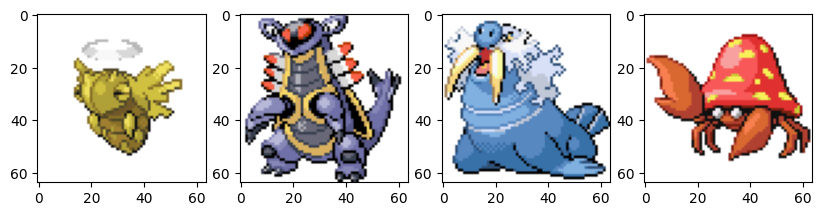

In [33]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
#x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [27]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    x = torch.randn((4,3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    plot_image(x[0], axes[0])
    plot_image(x[1], axes[1])
    plot_image(x[2], axes[2])
    plot_image(x[3], axes[3])
    plt.show()

    model.train()

In [ ]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 2000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')